# Milestone Project 2: SkimLit 📰🔥
The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve ther best results is available here: https://arxiv.org/abs/1612.05251

If you want to finde the ground truth of this notebook (with lots of diagrams and text annotations) see github.

## Confirm access to a GPU 

In [2]:
!nvidia-smi
!nvidia-smi -L

Tue Jul 19 05:45:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P5    19W /  N/A |   1188MiB /  6144MiB |     19%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data

Since we'll be replicating the paper above (PudMed 200k RCT), let's download the dataset they used.

We can do so from the authors github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [3]:
# Get data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [4]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt
test.txt
train.txt


In [5]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data
Now we've got some text data, it's time to become one with it.

And one of the best waysto become one with the data is to ...

> Visualize, visualize, visualize

So with that in mind, let's write a function to read in all of the lines of a target textfile.

In [7]:
# Create function to read the lines of a document
def get_lines(filename):
    """
    Reads filename (a text filename) and return the lines of the text as a list.

    Args:
        filename: a string containing the target filepath.

    Returns:
        A list of strings with one string per line from the target filename.
    """
    with open(filename, 'r') as f:
        return f.readlines()

In [8]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt")
train_lines[:25]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

Let's think about, how we want our data to look...

How I think our data would be best represented...

```
[{'line_number': '0',
    'target': 'Background'
    'text': "Emotional eating is associated with overeating and the development of obesity .\n"',
    'total_lines': '11'}]
```

Let's write a function which turns each of our datasets into the above format so we can conitnue prepare our data.



In [10]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.

    Takes in filename, reads it contents and sorts through each line,
    extracting things like the target label, the text of the sentence, 
    how many sentences are in the current abstract and what sentence
    number the target line is.
    """
    input_lines = get_lines(filename) # get all lines from filename
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list of abstracts

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith("###"): # Check to see if the line is an 1D line
            abstract_id = line
            abstract_lines = "" # reset the abstract string if the line is an 1D line
            
        elif line.isspace(): # check to see if line is a new line
            abstract_line_split = abstract_lines.splitlines() # split abstract into seperate lines
            
            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create an empty dictionary for each line
                target_text_split = abstract_line.split("\t") # split target label from text
                line_data["target"] = target_text_split[0] # get target label
                line_data["text"] = target_text_split[1].lower() # get target text and lower it
                line_data["line_number"] = abstract_line_number # what number line does the line appear in abstract?
                line_data["total_lines"] = len(abstract_line_split) - 1# How many total lines are ther in the targat abstract? (start from 0)
                abstract_samples.append(line_data) # add line data to abstract samples list

        else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_lines += line
        
    return abstract_samples

In [11]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt") # dev is another word for val
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [12]:
# Check the first abstract of our training data
train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
 # Distribution of labels in training data
 train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

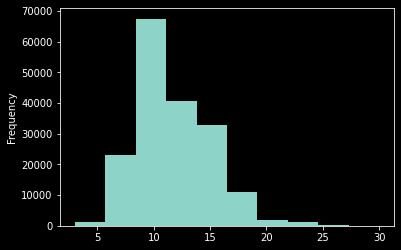

In [15]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get a list of sentences

In [16]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML Models require numeric labels)

In [18]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) 
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [19]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...
As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

### Model 0: Getting a baseline

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(
    X=train_sentences,
    y=train_labels_encoded
)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# Evaluate baseline model on validation dataset
model_0.score(
    X=val_sentences,
    y=val_labels_encoded
)

0.7218323844829869

In [23]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Download helper_functions.py
Import a function to compare predictions from previous model

In [25]:
import os
if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


In [26]:
from helper_functions import calculate_results

In [27]:
# Calculate baseline results
baseline_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=baseline_preds
)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Prepare our data (the text) for deep sequence model

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [29]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [30]:
# How long is each sentence on average?
sentence_length = [len(sentence.split()) for sentence in train_sentences]
    # going through all of the lines in train_sentences
avg_sentence_length = np.mean(sentence_length)
avg_sentence_length

26.338269273494777

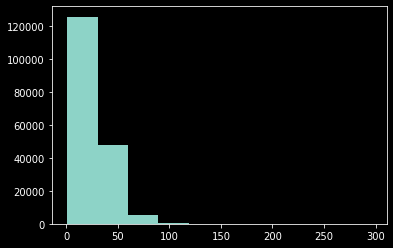

In [31]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sentence_length, bins=10);

In [32]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sentence_length, 95))
output_seq_len

55

In [33]:
# Maximum sequence length in the training set
max(sentence_length)

296

### Create text vectorizer layer

WE want to make a layer which maps our texts from words to numbers. 

In [34]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens=68_000

In [35]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer=TextVectorization(
    max_tokens=max_tokens, # num of words in vocabv
    output_sequence_length=output_seq_len # desired output length
)

In [36]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [37]:
# Test out text vectorizer of random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized test: \n{text_vectorizer([target_sentence])}")

Text:
for time assessing , analysis of variance with repeated measures was employed .

Length of text: 13

Vectorized test: 
[[  11   63 1332   85    4 1581    7  818  213   10 2696    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


Lower number mean, that the word is ranken higher in the vocab.

e.g. **the** is ranken two.

In [38]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [39]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False}

### Create custom text embedding

In [40]:
# Create token embedding layer
token_embed = layers.Embedding(
    input_dim=len(rct_20k_text_vocab),
    output_dim=128, # Note: different embedding sizes result in drastically different numbers or parameters to train
    mask_zero=True, # use masking to handel variable sequence length (even though our sequences have same length)
    name="Token_embedding"
)

In [41]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before the embedding)\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"After embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
for time assessing , analysis of variance with repeated measures was employed .

Sentence after vectorization (before the embedding)
[[  11   63 1332   85    4 1581    7  818  213   10 2696    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

After embedding:
[[[ 0.02829779 -0.01058758 -0.03173818 ...  0.03284338 -0.02759991
   -0.04353646]
  [-0.00026383 -0.00240747 -0.04046457 ... -0.03015115  0.04830721
   -0.01691282]
  [-0.02909966  0.01419691 -0.00738196 ... -0.00897121  0.03010816
    0.0371967 ]
  ...
  [-0.01727517 -0.03555423 -0.04421551 ...  0.00626511 -0.02700547
    0.02625329]
  [-0.01727517 -0.03555423 -0.04421551 ...  0.00626511 -0.02700547
    0.02625329]
  [-0.01727517 -0.03555423 -0.04421551 ...  0.00626511 -0.02700547
    0.02625329]]]

Embedded sentence shape: (

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length at these two ressources:
- https://www.tensorflow.org/guide/data_performance
- https://www.tensorflow.org/guide/data

In [42]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [43]:
print(train_labels_one_hot.shape)
print(train_labels_one_hot[0])

(180040, 5)
[0. 0. 0. 1. 0.]


In [44]:
# Take the TensorSliceDatasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1D with token embeddings

In [45]:
# Create 1D conv modcel to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors) 
x = layers.Conv1D(
    64, # multiple of 8 calculates good
    kernel_size=5, # looking at 5 words at once
    padding="same",
    activation="relu"
)(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(
    num_classes,
    activation="softmax",
)(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [46]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
Token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [47]:
# Fit
history_model_1 = model_1.fit(
    train_dataset, # it's a touple, which loads pretty fast and can be passed to fit (no need to pass labels, since they are included)
    steps_per_epoch=int(0.1*len(train_dataset)), # speed training up, since we want to find out what is not working and wand the models to fit fast
    epochs=3,
    validation_data=valid_dataset, # touple, too
    validation_steps=int(0.1*len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 14s 10ms/step - loss: 0.9113 - accuracy: 0.6410 - val_loss: 0.6837 - val_accuracy: 0.7374
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6615 - accuracy: 0.7533 - val_loss: 0.6368 - val_accuracy: 0.7663
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6238 - accuracy: 0.7694 - val_loss: 0.6045 - val_accuracy: 0.7822


In [48]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6069 - accuracy: 0.7829


[0.6068833470344543, 0.7828677296638489]

In [49]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.31193054e-01, 1.68333545e-01, 8.13245624e-02, 2.95320421e-01,
         2.38284897e-02],
        [4.51111257e-01, 2.69927591e-01, 1.38510419e-02, 2.58533537e-01,
         6.57660002e-03],
        [1.79914579e-01, 7.52284797e-03, 2.27550976e-03, 8.10253441e-01,
         3.36456651e-05],
        ...,
        [7.06043556e-06, 8.03434814e-04, 7.68960395e-04, 3.22615551e-06,
         9.98417258e-01],
        [4.80432026e-02, 4.23131526e-01, 1.03874415e-01, 6.04178756e-02,
         3.64532948e-01],
        [1.61274970e-01, 6.76569164e-01, 3.50682959e-02, 4.77649756e-02,
         7.93225914e-02]], dtype=float32),
 (30212, 5))

In [50]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:10], model_1_preds.shape

(<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 4, 2, 4, 2, 4, 1], dtype=int64)>,
 TensorShape([30212]))

In [51]:
class_names[model_1_preds]

array(['BACKGROUND', 'BACKGROUND', 'OBJECTIVE', ..., 'RESULTS',
       'CONCLUSIONS', 'CONCLUSIONS'], dtype=object)

In [52]:
# Calculate model 1 results
model_1_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_1_preds
)
model_1_results

{'accuracy': 78.28677346749636,
 'precision': 0.780150369510172,
 'recall': 0.7828677346749636,
 'f1': 0.7801098919923629}

In [53]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction
Now let's use pretrained word embeddings from TensorFlow Hub, more specifically universal sentence encoder (USE): https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.

> 📖 **Ressources:** For more information see:
* GloVe: https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010
* https://keras.io/examples/nlp/pretrained_word_embeddings/

In [54]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False,
    name="universal_sentence_encoder"
)

In [55]:
# Test out pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n{random_train_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
the primary outcome is the total diagnostic interval , defined as the duration from first symptom ( or date of cancer screening test ) to cancer diagnosis .

Sentence after embedding:
[ 0.01544299 -0.06762041 -0.02616701  0.00944538 -0.00629497 -0.08243469
 -0.02416385 -0.00522822  0.06289619  0.04182862  0.08345116 -0.07030562
  0.06640732 -0.06061889  0.0080006   0.05255318 -0.08345592  0.0386953
  0.08167301  0.04193273 -0.0220724   0.05397035  0.02147553  0.04131777
  0.03765085  0.04692527 -0.01739385 -0.03380855 -0.0397241   0.05703133]

Length of sentence embedding: 512


### Building and fitting a NLP feature extraction model using pretrained embeddings Tensorflow Hub

In [56]:
# Define feature extration model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string) # tf_hub_embedding layer expects an empty list as input
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [57]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [58]:
history_model_2 = model_2.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    epochs=3,
    validation_data=valid_dataset,
    validation_steps=int(0.1*len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 0.9201 - accuracy: 0.6497 - val_loss: 0.7992 - val_accuracy: 0.6875
Epoch 2/3
562/562 [==============================] - 8s 13ms/step - loss: 0.7712 - accuracy: 0.7002 - val_loss: 0.7579 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7555 - accuracy: 0.7092 - val_loss: 0.7430 - val_accuracy: 0.7134


In [59]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7439 - accuracy: 0.7132


[0.7439472079277039, 0.7132265567779541]

In [60]:
model_2_pred_probs = model_2.predict(valid_dataset)

In [61]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_2_preds
)
model_2_results

{'accuracy': 71.3226532503641,
 'precision': 0.7134080880754206,
 'recall': 0.713226532503641,
 'f1': 0.7101771302588237}

## Model 3: Conv1D with character embeddings

The paper we're replicatin states they used a combination of token and character-level embeddings.

Previously we've maken token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Create a character-level tokenizer

In [62]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [63]:
# Make function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

't h e   p r i m a r y   o u t c o m e   i s   t h e   t o t a l   d i a g n o s t i c   i n t e r v a l   ,   d e f i n e d   a s   t h e   d u r a t i o n   f r o m   f i r s t   s y m p t o m   (   o r   d a t e   o f   c a n c e r   s c r e e n i n g   t e s t   )   t o   c a n c e r   d i a g n o s i s   .'

In [64]:
list(train_sentences[0])

['t',
 'o',
 ' ',
 'i',
 'n',
 'v',
 'e',
 's',
 't',
 'i',
 'g',
 'a',
 't',
 'e',
 ' ',
 't',
 'h',
 'e',
 ' ',
 'e',
 'f',
 'f',
 'i',
 'c',
 'a',
 'c',
 'y',
 ' ',
 'o',
 'f',
 ' ',
 '@',
 ' ',
 'w',
 'e',
 'e',
 'k',
 's',
 ' ',
 'o',
 'f',
 ' ',
 'd',
 'a',
 'i',
 'l',
 'y',
 ' ',
 'l',
 'o',
 'w',
 '-',
 'd',
 'o',
 's',
 'e',
 ' ',
 'o',
 'r',
 'a',
 'l',
 ' ',
 'p',
 'r',
 'e',
 'd',
 'n',
 'i',
 's',
 'o',
 'l',
 'o',
 'n',
 'e',
 ' ',
 'i',
 'n',
 ' ',
 'i',
 'm',
 'p',
 'r',
 'o',
 'v',
 'i',
 'n',
 'g',
 ' ',
 'p',
 'a',
 'i',
 'n',
 ' ',
 ',',
 ' ',
 'm',
 'o',
 'b',
 'i',
 'l',
 'i',
 't',
 'y',
 ' ',
 ',',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 's',
 'y',
 's',
 't',
 'e',
 'm',
 'i',
 'c',
 ' ',
 'l',
 'o',
 'w',
 '-',
 'g',
 'r',
 'a',
 'd',
 'e',
 ' ',
 'i',
 'n',
 'f',
 'l',
 'a',
 'm',
 'm',
 'a',
 't',
 'i',
 'o',
 'n',
 ' ',
 'i',
 'n',
 ' ',
 't',
 'h',
 'e',
 ' ',
 's',
 'h',
 'o',
 'r',
 't',
 ' ',
 't',
 'e',
 'r',
 'm',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 'w',
 'h',
 'e'

In [65]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [66]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [67]:
# What's the average character length?
char_length = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_length)
mean_char_len

149.3662574983337

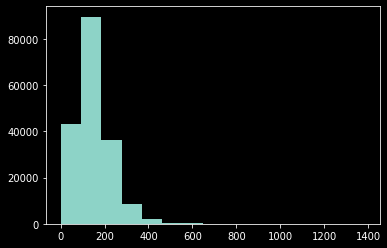

In [68]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_length, bins=15)
plt.show()

In [69]:
# Find what character-length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_length, 95))
output_seq_char_len

290

In [70]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [71]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKEN = len(alphabet) + 2 # add 2 for space and OOV (Out Of Vocab, '[UNK]') token
char_vectorizer = TextVectorization(
    max_tokens=NUM_CHAR_TOKEN,
    output_sequence_length=output_seq_char_len,
    # standardize="lower_and_strip_punctuation", # None, if you want to leave punctuation in
    name="char_vectorizer"
)

In [72]:
# Adaptr character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [73]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different character in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different character in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [74]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}\n")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}\n")
print(f"Length of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
b e t w e e n   j u n e   @   a n d   a u g u s t   @   ,   @   ,   m e n   w e r e   r e c r u i t e d   ,   c o m p l e t e d   b a s e l i n e   t e l e p h o n e   i n t e r v i e w s   ,   a n d   w e r e   t h a n   r a n d o m i z e d   t o   r e c e i v e   e i t h e r   a   v i d e o - b a s e d   i n t e r v e n t i o n   (   n   =   @   )   o r   b r o c h u r e s   o n l y   (   n   =   @   ;   o v e r a l l   r e s p o n s e   r a t e   , @   %   )   a n d   w e r e   a g a i n   i n t e r v i e w e d   @   m o n t h s   l a t e r   (   n   =   @   ;   @   %   r e t e n t i o n   )   .

Length of random_train_chars: 240

Vectorized chars:
[[22  2  3 20  2  2  6 27 16  6  2  5  6 10  5 16 18 16  9  3 15  2  6 20
   2  8  2  8  2 11  8 16  4  3  2 10 11  7 15 14 12  2  3  2 10 22  5  9
   2 12  4  6  2  3  2 12  2 14 13  7  6  2  4  6  3  2  8 21  4  2 20  9
   5  6 10 20  2  8  2  3 13  5  6  8  5  6 10  7 15  4 25  2 10  3  7  8
   2 11  2  4 21  2  2  4  3

## Creating a character-level embedding

In [75]:
# Create char embedding layer
char_embed = layers.Embedding(
    input_dim=len(char_vocab), # number of different characters
    output_dim=25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.0521.pdf (Figure 1)
    mask_zero=True,
    name="char_embed"
)

In [76]:
# Test out character embedding layer
print(f"Charified text:\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars: (after vectorization and embedding)\n{char_embed_example}")
print(f"Char embedding shape: {char_embed_example.shape}")

Charified text:
b e t w e e n   j u n e   @   a n d   a u g u s t   @   ,   @   ,   m e n   w e r e   r e c r u i t e d   ,   c o m p l e t e d   b a s e l i n e   t e l e p h o n e   i n t e r v i e w s   ,   a n d   w e r e   t h a n   r a n d o m i z e d   t o   r e c e i v e   e i t h e r   a   v i d e o - b a s e d   i n t e r v e n t i o n   (   n   =   @   )   o r   b r o c h u r e s   o n l y   (   n   =   @   ;   o v e r a l l   r e s p o n s e   r a t e   , @   %   )   a n d   w e r e   a g a i n   i n t e r v i e w e d   @   m o n t h s   l a t e r   (   n   =   @   ;   @   %   r e t e n t i o n   )   .

Embedded chars: (after vectorization and embedding)
[[[ 0.02575599  0.03166668  0.04454137 ...  0.03843338  0.00244848
    0.03285119]
  [ 0.02410937  0.01828471  0.02461387 ...  0.00781921  0.02734644
   -0.02757863]
  [-0.03190744 -0.03500273  0.00420003 ...  0.01155332 -0.01809676
   -0.03851395]
  ...
  [-0.01660427  0.03223361 -0.02631686 ... -0.00021625 -0.03414489
   

In [77]:
len(random_train_chars)

605

### Building a Conv1D model to fit on character embeddings

In [78]:
# make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_Conv1D_char_embeddings")

model_3.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [79]:
model_3.summary()

Model: "model_3_Conv1D_char_embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
__________________________________

In [80]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [81]:
len(train_chars), len(train_labels_one_hot), len(test_chars), len(test_labels_one_hot)

(180040, 180040, 30135, 30135)

In [82]:
model_3_history = model_3.fit(
    train_char_dataset,
    steps_per_epoch=int(0.1*len(train_char_dataset)),
    epochs=3,
    validation_data=val_char_dataset,
    validation_steps=int(0.1*len(val_char_dataset))
)

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2668 - accuracy: 0.4945 - val_loss: 1.0321 - val_accuracy: 0.5924
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9974 - accuracy: 0.6040 - val_loss: 0.9403 - val_accuracy: 0.6316
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9193 - accuracy: 0.6421 - val_loss: 0.8638 - val_accuracy: 0.6712


In [83]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.8797 - accuracy: 0.6596


[0.8796873688697815, 0.6595723628997803]

In [84]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_3_preds
)
model_3_results

{'accuracy': 65.95723553554879,
 'precision': 0.6530623315086079,
 'recall': 0.6595723553554879,
 'f1': 0.6481496171024832}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)
1. Create a token-level embedding (similar `model_1`)
2. Create a character-level model (similar `model_3`)
3. Combine (1) & (2) with a concatenate layer (`layers.concatenat`)
4. Build a series of output layers on top of (3) similar to Figure 1 and section 4.2 of the paper: https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequence as input an produces sequence label probabilities as output

In [85]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(
    inputs=token_inputs,
    outputs=token_outputs
)

In [86]:
# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi lstm shown in Figure 1
char_model = tf.keras.Model(
    inputs=char_inputs,
    outputs=char_bi_lstm
)

In [87]:
# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")\
    ([token_model.output, char_model.output])

In [88]:
# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [89]:
# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(
    inputs=[
        token_model.input,
        char_model.input
    ],
    outputs=output_layer,
    name="model_4_token_and_char_embeddings"
)

model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

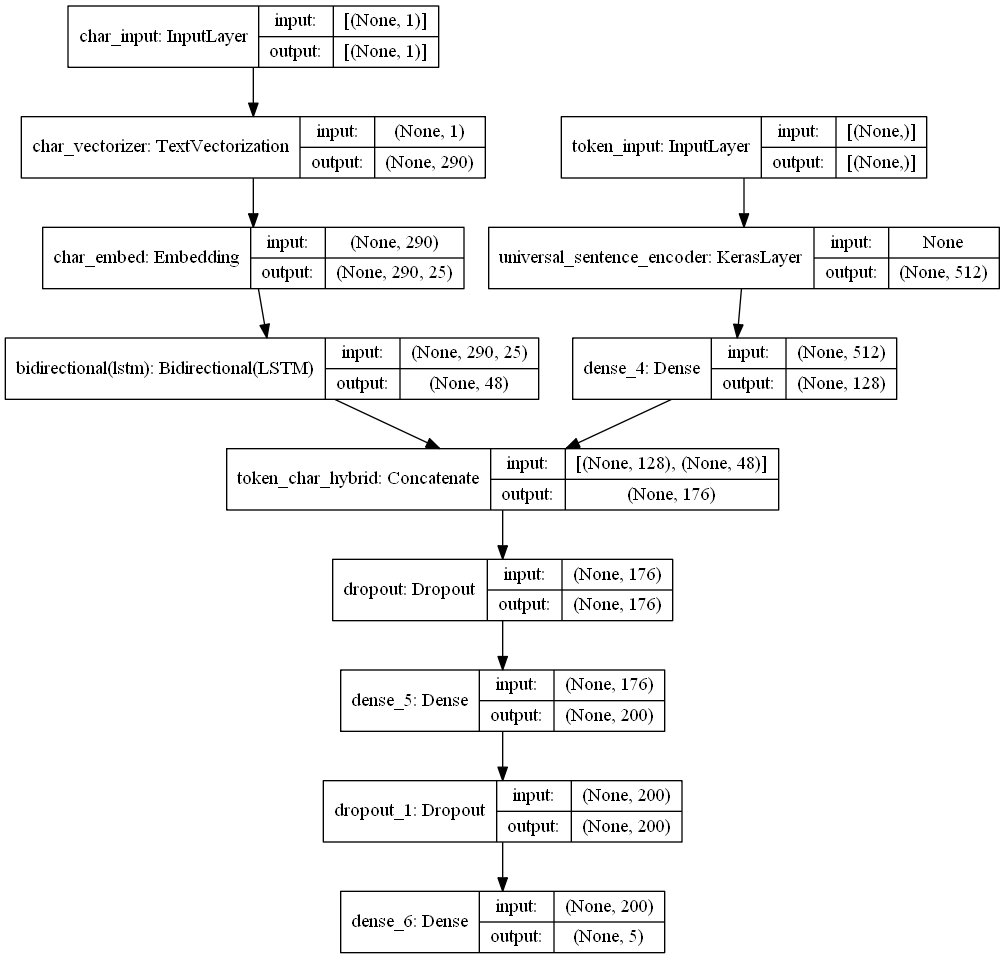

In [90]:
# Plot hybrid token and character model
from keras.utils.vis_utils import plot_model
plot_model(model_4, show_shapes=True)

In [91]:
# Compile
model_4.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

### Combining token and character data into a `tf.data.Dataset`

In [92]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

In [93]:
# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [94]:
# Combine chars and token into performant dataset
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [95]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset, test_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

In [96]:
# Fit
model_4.fit(
    train_char_token_dataset,
    steps_per_epoch=int(0.1*len(train_char_token_dataset)),
    epochs=3,
    validation_data=val_char_token_dataset,
    validation_steps=int(0.1*len(val_char_token_dataset))
)

Epoch 1/3
562/562 [==============================] - 45s 68ms/step - loss: 0.9728 - accuracy: 0.6115 - val_loss: 0.7867 - val_accuracy: 0.6968
Epoch 2/3
562/562 [==============================] - 37s 67ms/step - loss: 0.7915 - accuracy: 0.6952 - val_loss: 0.7155 - val_accuracy: 0.7261
Epoch 3/3
562/562 [==============================] - 35s 63ms/step - loss: 0.7649 - accuracy: 0.7081 - val_loss: 0.6942 - val_accuracy: 0.7294


In [97]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)

In [98]:
model_4_results = calculate_results(
    y_true = val_labels_encoded,
    y_pred = model_4_preds
)
model_4_results

{'accuracy': 73.25896994571693,
 'precision': 0.7365795269023526,
 'recall': 0.7325896994571693,
 'f1': 0.7297731005783762}

## Model 5: Transfer learning with pretrained token embeddings plus character embeddings

In [99]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> 🔑**Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [101]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

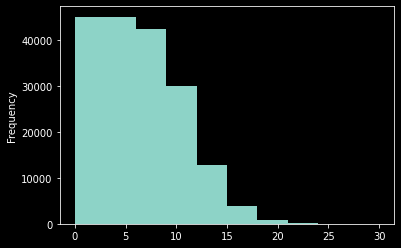

In [102]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [105]:
# Use TensorFlow to create one-hot-encoded tensors of our line_number problem
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now we've encoded our line numbers feature, let's doe the same for out total lines feature...

In [106]:
# How many different number of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

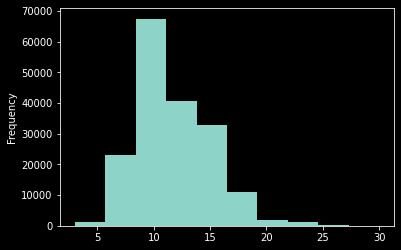

In [107]:
# Check the distributions of total lines
train_df.total_lines.plot.hist();

In [109]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [116]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10], train_df.total_lines[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the `line_number` feature
4. Create a model for the `total_lines` feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3, 4 & 5 using `tf.keras.layers.Concatenat`
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3 & 4 and the outputs of 6 into a `tf.keras.Model`

In [140]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_embeddings")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs) # turn chars into integers
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15, ), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

# 4. Total lines
total_lines_inputs = layers.Input(shape=(20, ), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")\
    ([token_model.output, char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6.  Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")\
    ([line_number_model.output, total_lines_model.output, z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(
    inputs=[line_number_model.input, total_lines_model.input, token_model.input, char_model.input],
    outputs=output_layer,
    name="model_5_tribrid_embedding_model"
)

In [141]:
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_embeddings (InputLayer)   [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_embeddings[0][0]           
____________________________________________________________________

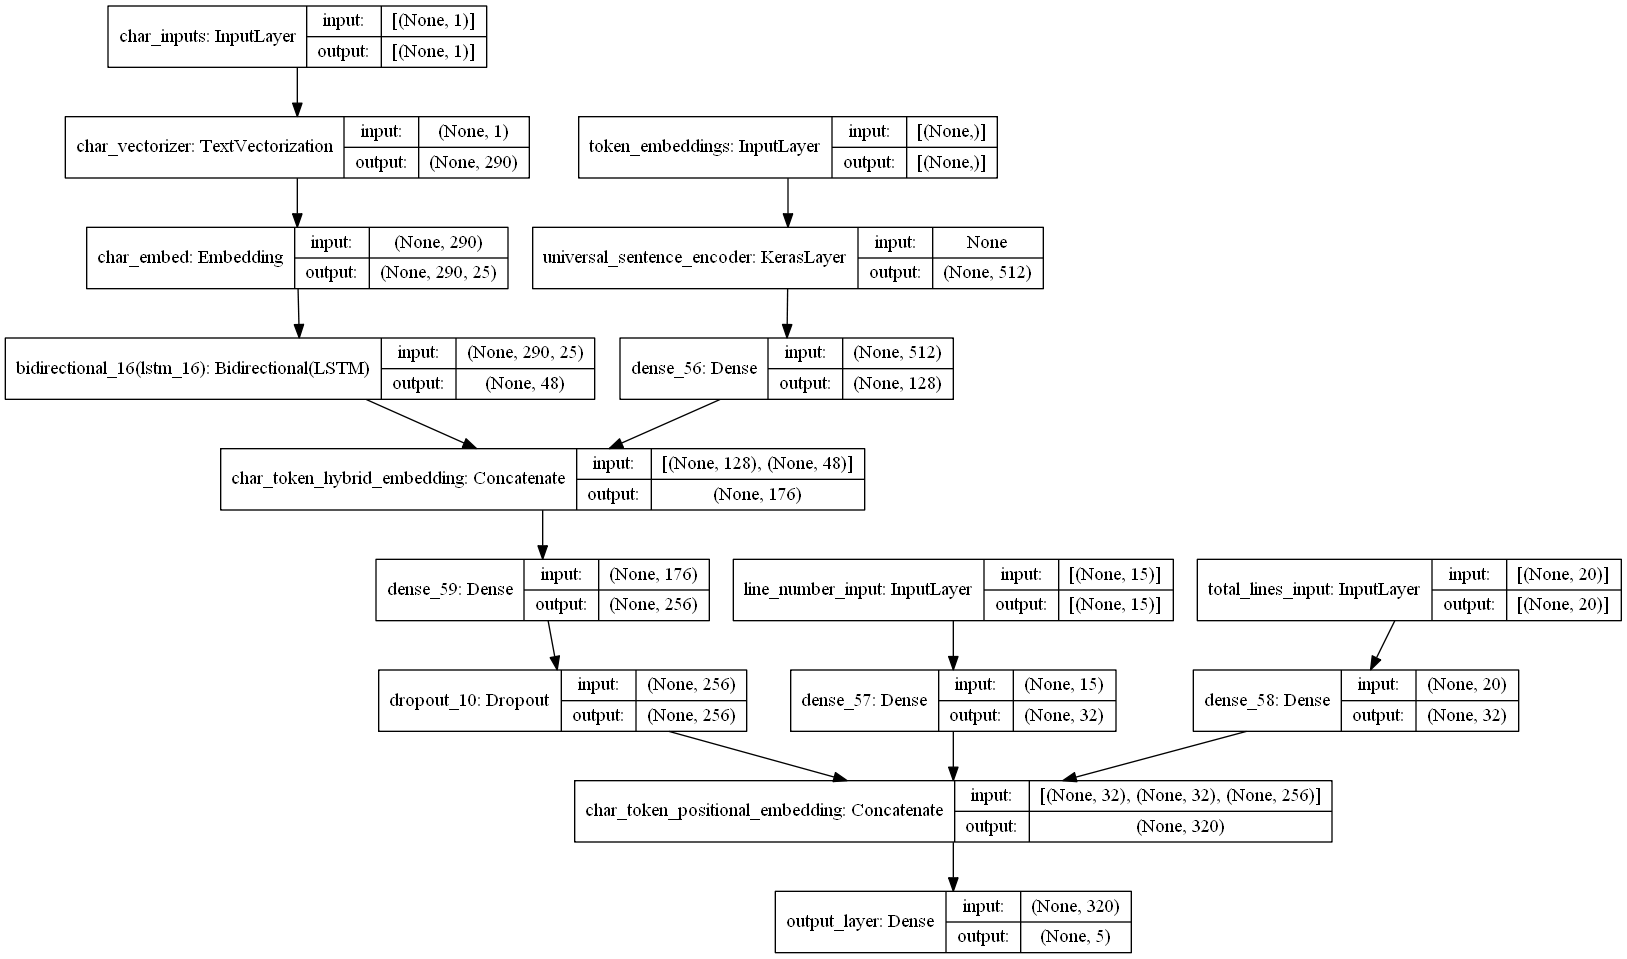

In [146]:
# Plot model_5 to explore it visually
from keras.utils.vis_utils import plot_model
plot_model(model_5, show_shapes=True)

What is label smoothin?

For example, if our model gets too confident on a single class (eg.g its predction probability is really high), it may get stuck on that class and not consider other classes.

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is, it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]` 

> 📖 **Ressource:** For more on label smoothing see this blogpost from PyImageSearch: https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [145]:
# Compile token, char and positional embedding model
model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

### Create tribrid embedding datasets using tf.data